**IMPORTA AS BIBLIOTECAS**

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import copy
import pandas as pd
from scipy.stats import beta


**LEITURA DOS ARQUIVOS**

In [112]:
class Struct:
    pass

def wrap_struct(solution):
    x = Struct()
    x.solution = solution
    return x

path_equip = 'Dados/EquipDB.csv'
path_planos = 'Dados/MPDB.csv'
path_cluster = 'Dados/ClusterDB.csv'

Equipamentos = pd.read_csv(path_equip, header=None, names=["ID", "t0", "cluster", "custo de falha"])
Planos = pd.read_csv(path_planos, header=None, names=["ID", "k", "custo"])
ModeloFalha = pd.read_csv(path_cluster, header=None, names=["ID", "eta", "beta"])

# Estrutura de dados
def manutencao_def(equipamentos, planos):
    dados = Struct()
    dados.equipamentos = equipamentos
    dados.planos = planos.set_index("ID")
    dados.modelo_falha = ModeloFalha.set_index("ID")
    dados.n = len(equipamentos)
    dados.custo_por_plano = dados.planos["custo"].to_dict()
    return dados

**SOLUÇÃO INICIAL**

In [113]:
def Sol_Inicial(dados):
    n = dados.n
    delta_t = 5
    custo_beneficio = np.zeros(n)

    for i in range(n):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq['cluster']]
        t0 = eq['t0']
        custo_falha = eq['custo de falha']
        custo_manut = dados.planos.loc[1, 'custo']
        
        # Proteção contra divisão por zero
        if custo_manut == 0:
            custo_beneficio[i] = float('inf')
            continue
            
        eta = cluster['eta']
        beta = cluster['beta']
        Fi = lambda t: 1 - np.exp(-(t/eta)**beta)
        pi = (Fi(t0 + 5) - Fi(t0)) / (1 - Fi(t0) + 1e-10)  # +1e-10 para evitar divisão por zero
        
        custo_beneficio[i] = (pi * custo_falha) / custo_manut

    indices_ordenados = np.argsort(custo_beneficio)
    sol_inicial = np.ones(n, dtype=int)
    
    # Distribuição mais suave
    for i, idx in enumerate(indices_ordenados):
        if i < n//3:
            sol_inicial[idx] = 1
        elif i < 2*n//3:
            sol_inicial[idx] = 2
        else:
            sol_inicial[idx] = 3
            
    return sol_inicial

In [ ]:
# def Sol_Inicial(dados):
#     n = dados.n
#     # Define vetor com plano 1 para todos equipamentos
#     sol_inicial = np.ones(n, dtype=int)
#     return sol_inicial

**FUNÇÕES OBJETIVO**

In [114]:
def fobj_f1(x, dados):
    custo_total = sum(dados.custo_por_plano[plano] for plano in x.solution)
    x.fitness = custo_total
    return x

def fobj_f2(x, dados):
    custo = 0
    for i, plano in enumerate(x.solution):
        eq = dados.equipamentos.iloc[i]
        cluster = dados.modelo_falha.loc[eq["cluster"]]
        plano_info = dados.planos.loc[plano]

        t0 = eq["t0"]
        k = plano_info["k"]
        delta_t = 5
        eta = cluster["eta"]
        beta = cluster["beta"]

        Fi = lambda t: 1 - np.exp(-(t / eta)**beta)
        pi = (Fi(t0 + k * delta_t) - Fi(t0)) / (1 - Fi(t0))
        custo += pi * eq["custo de falha"]

    x.fitness = custo
    return x

**GVNS - Busca Local**

In [115]:
def busca_local_gvns(solucao, vizinhancas, fobj, dados, max_avaliacoes, r):
    x = copy.deepcopy(solucao)
    avaliacoes = 0
    melhorou = True

    while melhorou and avaliacoes < max_avaliacoes:
        melhorou = False
        for viz in vizinhancas:
            y = viz(x, r)
            y = fobj(y, dados)
            avaliacoes += 1
            if y.fitness < x.fitness:
                x = copy.deepcopy(y)
                melhorou = True
                break
    return x, avaliacoes

**GVNS**

In [ ]:
def gvns(sol_inicial, fobj, max_iter, k_max, vizinhancas, dados, r=10):
    x = wrap_struct(sol_inicial())
    x = fobj(x, dados)
    melhor = copy.deepcopy(x)
    num_avaliadas = 1
    historico = [melhor.fitness]

    while num_avaliadas < max_iter:
        k = 0
        while k < k_max and num_avaliadas < max_iter:
            # Shaking - perturba solução atual na vizinhança k
            y = vizinhancas[k](x, r)
            y = fobj(y, dados)
            num_avaliadas += 1

            # Busca local a partir de y
            y_local, avals = busca_local_gvns(y, vizinhancas, fobj, dados, max_iter - num_avaliadas, r)
            num_avaliadas += avals
            y = y_local

            # Critério de aceitação simples: se melhor, aceita
            if y.fitness < melhor.fitness:
                melhor = copy.deepcopy(y)
                x = copy.deepcopy(y)
                k = 0  # volta para menor vizinhança
            else:
                k += 1

            historico.append(melhor.fitness)

    return melhor, historico

**GVNS - Operadores de Vizinhança**

In [117]:
def shake(x, r, planos=3):
    """
    Troca o plano de manutenção de r equipamentos aleatórios para outro plano diferente.
    """
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        opcoes = [p for p in range(1, planos+1) if p != y.solution[idx]]
        y.solution[idx] = np.random.choice(opcoes)
    return y

def shake_adiciona(x, r, planos=3):
    """
    Incrementa o plano de manutenção em r equipamentos (se não estiver no máximo).
    """
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        if y.solution[idx] < planos:
            y.solution[idx] += 1
    return y

def shake_subtrai(x, r):
    """
    Decrementa o plano de manutenção em r equipamentos (se não estiver no mínimo).
    """
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        if y.solution[idx] > 1:
            y.solution[idx] -= 1
    return y

def shake_balanceado(x, r):
    """Operador que busca soluções intermediárias"""
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        # Tendência a escolher planos intermediários (plano 2)
        y.solution[idx] = np.random.choice([1, 2, 3], p=[0.3, 0.4, 0.3])
    return y

def shake_intermediario(x, r):
    """Foca em soluções balanceadas"""
    y = copy.deepcopy(x)
    indices = np.random.choice(len(y.solution), size=r, replace=False)
    for idx in indices:
        current = y.solution[idx]
        if current == 1:
            y.solution[idx] = 2  # Só melhora
        elif current == 3:
            y.solution[idx] = 2  # Só piora
        else:
            y.solution[idx] = np.random.choice([1, 2, 3])
    return y


**ENCONTRA EXTREMOS**

In [118]:
def encontrar_extremos(dados, max_iter=1000):
    if hasattr(dados, 'extremos'):
        return dados.extremos
        
    print("Calculando extremos monoobjetivo...")
    
    # Função auxiliar para evitar código duplicado
    def optimizar(fobj):
        return gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iter,
            k_max=3,
            vizinhancas=[shake_adiciona, shake_subtrai, shake],
            dados=dados,
            r=10
        )

    best_f1, _ = optimizar(lambda x, dados=dados: fobj_f1(x, dados))
    best_f2, _ = optimizar(lambda x, dados=dados: fobj_f2(x, dados))
    
    dados.extremos = {
        "min_f1": best_f1.fitness,
        "max_f1": fobj_f1(copy.deepcopy(best_f2), dados).fitness,
        "min_f2": best_f2.fitness,
        "max_f2": fobj_f2(copy.deepcopy(best_f1), dados).fitness
    }
    
    print(f"Extremos calculados: F1=[{dados.extremos['min_f1']:.2f}, {dados.extremos['max_f1']:.2f}] "
          f"F2=[{dados.extremos['min_f2']:.2f}, {dados.extremos['max_f2']:.2f}]")
    
    return dados.extremos

In [119]:
def encontrar_extremos_rapido(dados, max_iter=30):
    if hasattr(dados, 'extremos'):
        return dados.extremos
    
    def optimizar(fobj):
        return gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iter,
            k_max=3,
            vizinhancas=[shake_adiciona, shake_subtrai, shake],
            dados=dados,
            r=10
        )

    best_f1, _ = optimizar(lambda x, dados=dados: fobj_f1(x, dados))
    best_f2, _ = optimizar(lambda x, dados=dados: fobj_f2(x, dados))
    
    dados.extremos = {
        "min_f1": best_f1.fitness,
        "max_f1": fobj_f1(copy.deepcopy(best_f2), dados).fitness,
        "min_f2": best_f2.fitness,
        "max_f2": fobj_f2(copy.deepcopy(best_f1), dados).fitness
    }
    return dados.extremos


**FUNÇÃO SOMA PONDERADA**

In [120]:
def soma_ponderada(x, dados, peso_f1):
    if not hasattr(dados, 'extremos'):
        dados.extremos = encontrar_extremos(dados)
    
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    # Normalização com proteção
    range_f1 = dados.extremos['max_f1'] - dados.extremos['min_f1']
    range_f2 = dados.extremos['max_f2'] - dados.extremos['min_f2']
    
    f1_norm = (f1 - dados.extremos['min_f1']) / (range_f1 + 1e-10)
    f2_norm = (f2 - dados.extremos['min_f2']) / (range_f2 + 1e-10)
    
    # # Ponderação adaptativa
    # peso_efetivo = peso_f1
    # if 30 <= peso_f1 <= 70:  # Região intermediária
    #     peso_efetivo = peso_f1**1.2  # Aumenta a influência
        
    x.fitness = (f1_norm * peso_f1 + f2_norm * (100 - peso_f1)) / 100
    return x

In [121]:
def soma_ponderada_rapida(x, dados, peso_f1):
    if not hasattr(dados, 'extremos'):
        dados.extremos = encontrar_extremos_rapido(dados)
    
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    range_f1 = dados.extremos['max_f1'] - dados.extremos['min_f1']
    range_f2 = dados.extremos['max_f2'] - dados.extremos['min_f2']
    
    f1_norm = (f1 - dados.extremos['min_f1']) / (range_f1 + 1e-10)
    f2_norm = (f2 - dados.extremos['min_f2']) / (range_f2 + 1e-10)
    
    x.fitness = (f1_norm * peso_f1 + f2_norm * (100 - peso_f1)) / 100
    return x

In [122]:
def gerar_pesos_beta(num_pontos=20, a=2, b=2):
    x = np.linspace(0, 1, num_pontos)
    pesos_pdf = beta.pdf(x, a, b)
    pesos_norm = (pesos_pdf - pesos_pdf.min()) / (pesos_pdf.max() - pesos_pdf.min())
    pesos = pesos_norm * 100
    return pesos

# Gerar fronteira Pareto soma ponderada rápida
def gerar_fronteira_pareto(dados, num_pontos=20, max_iteracoes=50, num_repeticoes=5):
    pesos = gerar_pesos_beta(num_pontos)
    resultados_f1, resultados_f2 = [], []

    vizinhancas = [shake_intermediario, shake_balanceado, shake_adiciona, shake_subtrai, shake]

    for i, peso in enumerate(pesos):
        print(f"Processando peso {i+1}/{len(pesos)}: F1={peso:.1f}%")

        melhor_solucao = None
        melhor_fitness = float('inf')

        for rep in range(num_repeticoes):
            fobj = lambda x, dados=dados, peso=peso: soma_ponderada_rapida(x, dados, peso)

            best, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=fobj,
                max_iter=max_iteracoes,
                k_max=len(vizinhancas),
                vizinhancas=vizinhancas,
                dados=dados,
                r=max(5, int(len(dados.equipamentos)*0.1))
            )

            f1 = fobj_f1(best, dados).fitness
            f2 = fobj_f2(best, dados).fitness

            fitness_atual = fobj(best, dados, peso).fitness

            if fitness_atual < melhor_fitness:
                melhor_fitness = fitness_atual
                melhor_solucao = (f1, f2)

        resultados_f1.append(melhor_solucao[0])
        resultados_f2.append(melhor_solucao[1])

    return resultados_f1, resultados_f2

**FUNÇÃO EPSILON RESTRITO**

In [123]:
def fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal='f1'):
    """
    Função objetivo ϵ-restrito aprimorada.
    
    Args:
        x: Solução candidata
        dados: Dados do problema
        epsilon: Valor limite para a função objetivo restrita
        objetivo_principal: Qual função será otimizada ('f1' ou 'f2')
    
    Returns:
        x com fitness calculado (com penalização adaptativa se violar a restrição)
    """
    # Calcula ambos os objetivos uma única vez
    f1 = fobj_f1(copy.deepcopy(x), dados).fitness
    f2 = fobj_f2(copy.deepcopy(x), dados).fitness
    
    if objetivo_principal == 'f1':
        # Minimiza f1 sujeito a f2 <= epsilon
        if f2 <= epsilon:
            x.fitness = f1
        else:
            # Penalização adaptativa proporcional à violação
            violacao = f2 - epsilon
            x.fitness = f1 + 1e6 * violacao  # Fator grande para garantir dominância
    else:
        # Minimiza f2 sujeito a f1 <= epsilon
        if f1 <= epsilon:
            x.fitness = f2
        else:
            violacao = f1 - epsilon
            x.fitness = f2 + 1e6 * violacao
    
    return x



**FRONTEIRA PARETO - Epsilon Restrito**

In [124]:
def gerar_fronteira_epsilon(dados, num_pontos=20, max_iteracoes=100, objetivo_principal='f1'):
    print("Calculando soluções extremas para determinar faixa de epsilon...")

    extremos_cache = {}

    def calcular_extremos():
        if not extremos_cache:
            best_f1, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=lambda x, dados=dados: fobj_f1(x, dados),
                max_iter=max_iteracoes,
                k_max=3,
                vizinhancas=[shake_adiciona, shake_subtrai, shake],
                dados=dados,
                r=10
            )
            best_f2, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=lambda x, dados=dados: fobj_f2(x, dados),
                max_iter=max_iteracoes,
                k_max=3,
                vizinhancas=[shake_adiciona, shake_subtrai, shake],
                dados=dados,
                r=10
            )

            extremos_cache.update({
                'min_f1': best_f1.fitness,
                'max_f2': fobj_f2(copy.deepcopy(best_f1), dados).fitness,
                'max_f1': fobj_f1(copy.deepcopy(best_f2), dados).fitness,
                'min_f2': best_f2.fitness
            })
        return extremos_cache

    extremos = calcular_extremos()

    if objetivo_principal == 'f1':
        epsilons = np.logspace(np.log10(extremos['min_f2']),
                              np.log10(extremos['max_f2']),
                              num_pontos)
    else:
        epsilons = np.logspace(np.log10(extremos['min_f1']),
                              np.log10(extremos['max_f1']),
                              num_pontos)

    resultados_f1 = []
    resultados_f2 = []
    solucoes_validas = 0

    for eps in epsilons:
        print(f"\nOtimizando com epsilon = {eps:.2f} (Progresso: {len(resultados_f1)+1}/{num_pontos})")

        fobj = lambda x, dados=dados, epsilon=eps: fobj_epsilon_restrito(x, dados, epsilon, objetivo_principal)

        best, _ = gvns(
            sol_inicial=lambda: Sol_Inicial(dados),
            fobj=fobj,
            max_iter=max_iteracoes,
            k_max=3,
            vizinhancas=[shake_adiciona, shake_subtrai, shake],
            dados=dados,
            r=max(5, int(len(dados.equipamentos) * 0.02))
        )

        f1 = fobj_f1(copy.deepcopy(best), dados).fitness
        f2 = fobj_f2(copy.deepcopy(best), dados).fitness

        if (objetivo_principal == 'f1' and f2 <= eps) or (objetivo_principal == 'f2' and f1 <= eps):
            solucoes_validas += 1
            resultados_f1.append(f1)
            resultados_f2.append(f2)
        else:
            print(f"Solução inválida encontrada para eps={eps:.2f} - descartando")

    print(f"\nEstatísticas:")
    print(f"- Total de pontos tentados: {num_pontos}")
    print(f"- Soluções válidas encontradas: {solucoes_validas} ({solucoes_validas/num_pontos:.1%})")

    return resultados_f1, resultados_f2

**PESO LOGARITIMICO**

In [125]:
def gerar_pesos_logaritmicos(num_pontos=20, a=2, b=2):
    x = np.linspace(0, 1, num_pontos)
    
    pesos = np.zeros_like(x)
    
    # Parte 1: crescimento rápido até 0.2 (20%)
    mask1 = x <= 0.2
    pesos[mask1] = (x[mask1] / 0.2)**0.5  # raiz quadrada para crescimento rápido
    
    # Parte 2: crescimento lento entre 0.2 e 0.6 (20%-60%)
    mask2 = (x > 0.2) & (x <= 0.6)
    pesos[mask2] = 1 + 0.2 * ((x[mask2] - 0.2) / 0.4)  # crescimento linear lento
    
    # Parte 3: crescimento rápido de 0.6 a 1 (60%-100%)
    mask3 = x > 0.6
    pesos[mask3] = 1.2 + 0.8 * ((x[mask3] - 0.6) / 0.4)**2  # quadrado para crescimento rápido
    
    # Normaliza para [1, 100]
    pesos = 1 + 99 * (pesos - pesos.min()) / (pesos.max() - pesos.min())
    
    return pesos

In [ ]:
def plot_distribuicao_pesos():
    pesos = gerar_pesos_beta(10)
    
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(pesos)), pesos, c='blue', s=100)
    plt.title("Distribuição Logarítmica dos Pesos (Versão Aprimorada)", fontsize=14)
    plt.xlabel("Índice do Ponto", fontsize=12)
    plt.ylabel("Peso F1 (%)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(0, 20, 2))
    plt.yticks(range(0, 110, 10))
    plt.show()

plot_distribuicao_pesos()

**FRONTEIRA PARETO - Soma Ponderada**

In [128]:
def gerar_fronteira_pareto(dados, num_pontos=20, max_iteracoes=50, num_repeticoes=5):
    pesos = gerar_pesos_beta(num_pontos)
    resultados_f1, resultados_f2 = [], []

    vizinhancas = [shake_intermediario, shake_balanceado, shake_adiciona, shake_subtrai, shake]

    for i, peso in enumerate(pesos):
        print(f"Processando peso {i+1}/{len(pesos)}: F1={peso:.1f}%")

        melhor_solucao = None
        melhor_fitness = float('inf')

        for rep in range(num_repeticoes):
            fobj = lambda x, dados=dados, peso=peso: soma_ponderada_rapida(x, dados, peso)

            best, _ = gvns(
                sol_inicial=lambda: Sol_Inicial(dados),
                fobj=fobj,
                max_iter=max_iteracoes,
                k_max=len(vizinhancas),
                vizinhancas=vizinhancas,
                dados=dados,
                r=max(5, int(len(dados.equipamentos)*0.1))
            )

            f1 = fobj_f1(best, dados).fitness
            f2 = fobj_f2(best, dados).fitness

            fitness_atual = fobj(best, dados, peso).fitness

            if fitness_atual < melhor_fitness:
                melhor_fitness = fitness_atual
                melhor_solucao = (f1, f2)

        resultados_f1.append(melhor_solucao[0])
        resultados_f2.append(melhor_solucao[1])

    return resultados_f1, resultados_f2


**GERA RESULTADOS - Pw**


Gerando fronteira com Soma Ponderada Rápida...
Processando peso 1/10: F1=0.0%
Processando peso 2/10: F1=40.0%
Processando peso 3/10: F1=70.0%
Processando peso 4/10: F1=90.0%
Processando peso 5/10: F1=100.0%
Processando peso 6/10: F1=100.0%
Processando peso 7/10: F1=90.0%
Processando peso 8/10: F1=70.0%
Processando peso 9/10: F1=40.0%
Processando peso 10/10: F1=0.0%


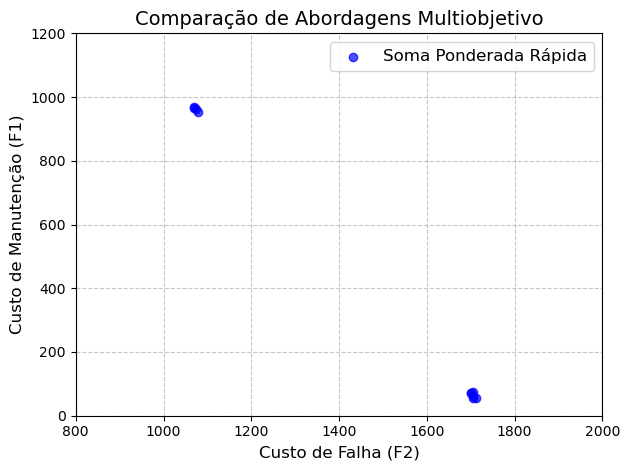

In [129]:
def gerar_resultados_pw(dados, num_pontos=20, max_iteracoes=30):
    print("\nGerando fronteira com Soma Ponderada Rápida...")
    f1_pw, f2_pw = gerar_fronteira_pareto(dados, num_pontos, max_iteracoes, num_repeticoes=2)
    
    plt.scatter(f2_pw, f1_pw, c='blue', marker='o', label='Soma Ponderada Rápida', alpha=0.7)
    
    plt.title("Comparação de Abordagens Multiobjetivo", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.xlim(800, 2000)
    plt.ylim(0, 1200)
    
    plt.tight_layout()
    plt.show()
    
    return f1_pw, f2_pw

if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    
    # Gerar apenas Pw rápido
    f1_pw, f2_pw = gerar_resultados_pw(dados, num_pontos=10, max_iteracoes=100)

    



**GERA RESULTADOS - e-restrito F1**


Gerando fronteira com ϵ-restrito (min F1)...
Calculando soluções extremas para determinar faixa de epsilon...

Otimizando com epsilon = 1135.29 (Progresso: 1/20)
Solução inválida encontrada para eps=1135.29 - descartando

Otimizando com epsilon = 1155.33 (Progresso: 1/20)

Otimizando com epsilon = 1175.72 (Progresso: 2/20)

Otimizando com epsilon = 1196.46 (Progresso: 3/20)

Otimizando com epsilon = 1217.58 (Progresso: 4/20)

Otimizando com epsilon = 1239.06 (Progresso: 5/20)

Otimizando com epsilon = 1260.93 (Progresso: 6/20)

Otimizando com epsilon = 1283.18 (Progresso: 7/20)

Otimizando com epsilon = 1305.83 (Progresso: 8/20)

Otimizando com epsilon = 1328.87 (Progresso: 9/20)

Otimizando com epsilon = 1352.32 (Progresso: 10/20)

Otimizando com epsilon = 1376.18 (Progresso: 11/20)

Otimizando com epsilon = 1400.47 (Progresso: 12/20)

Otimizando com epsilon = 1425.18 (Progresso: 13/20)

Otimizando com epsilon = 1450.33 (Progresso: 14/20)

Otimizando com epsilon = 1475.93 (Progresso:

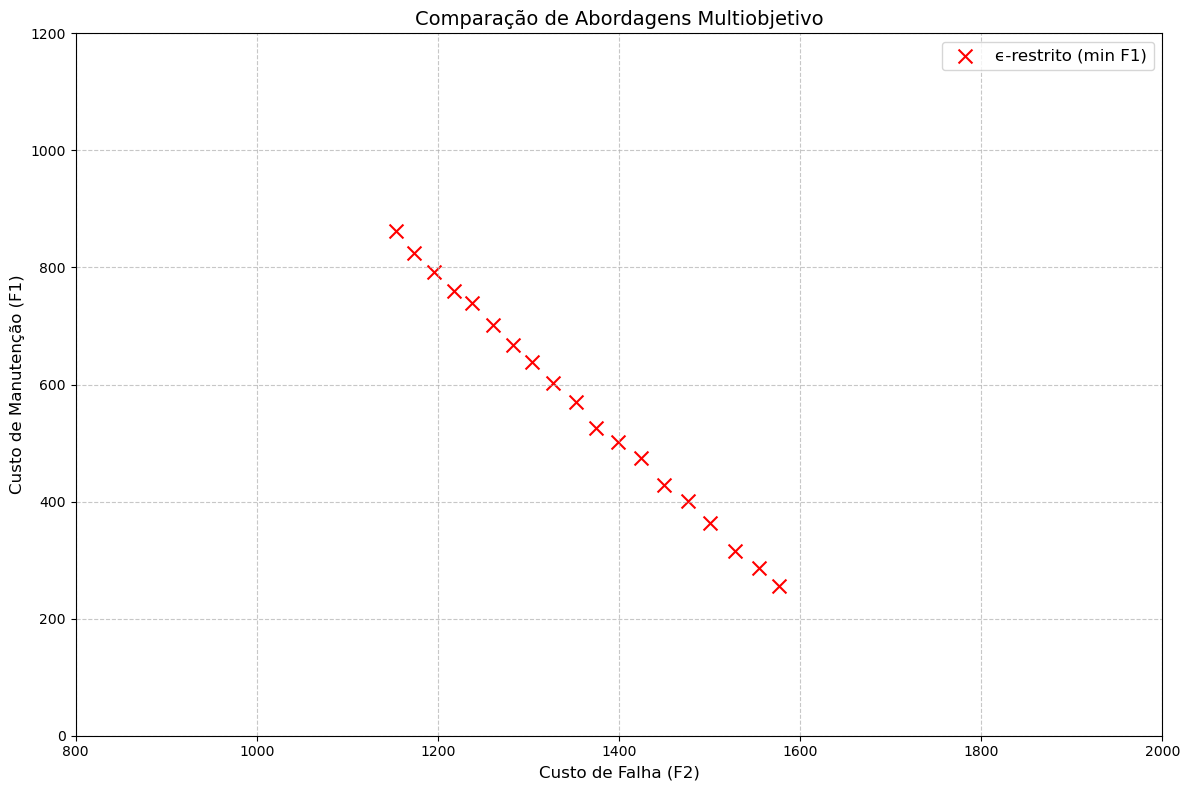

In [130]:
def gerar_resultados_epsilon_f1(dados, num_pontos=20, max_iteracoes=100):
    print("\nGerando fronteira com ϵ-restrito (min F1)...")
    f1_eps1, f2_eps1 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f1')
    
    plt.figure(figsize=(12, 8))

    # ϵ-restrito (min f1)
    plt.scatter(f2_eps1, f1_eps1, c='red', marker='x', label='ϵ-restrito (min F1)', s=100)
    
    plt.title("Comparação de Abordagens Multiobjetivo", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.xlim(800, 2000)
    plt.ylim(0, 1200)
    
    plt.tight_layout()
    plt.show()
    
    return f1_eps1, f2_eps1

if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    
    # Gerar apenas epsilon min f1
    f1_eps1, f2_eps1 = gerar_resultados_epsilon_f1(dados, num_pontos=20, max_iteracoes=100)

**GERA RESULTADOS - e-restrito F2**


Gerando fronteira com ϵ-restrito (min F2)...
Calculando soluções extremas para determinar faixa de epsilon...

Otimizando com epsilon = 263.00 (Progresso: 1/20)
Solução inválida encontrada para eps=263.00 - descartando

Otimizando com epsilon = 280.53 (Progresso: 1/20)

Otimizando com epsilon = 299.22 (Progresso: 2/20)

Otimizando com epsilon = 319.16 (Progresso: 3/20)

Otimizando com epsilon = 340.43 (Progresso: 4/20)

Otimizando com epsilon = 363.12 (Progresso: 5/20)

Otimizando com epsilon = 387.32 (Progresso: 6/20)

Otimizando com epsilon = 413.13 (Progresso: 7/20)

Otimizando com epsilon = 440.66 (Progresso: 8/20)

Otimizando com epsilon = 470.03 (Progresso: 9/20)

Otimizando com epsilon = 501.35 (Progresso: 10/20)

Otimizando com epsilon = 534.76 (Progresso: 11/20)

Otimizando com epsilon = 570.40 (Progresso: 12/20)

Otimizando com epsilon = 608.41 (Progresso: 13/20)

Otimizando com epsilon = 648.96 (Progresso: 14/20)

Otimizando com epsilon = 692.20 (Progresso: 15/20)

Otimizan

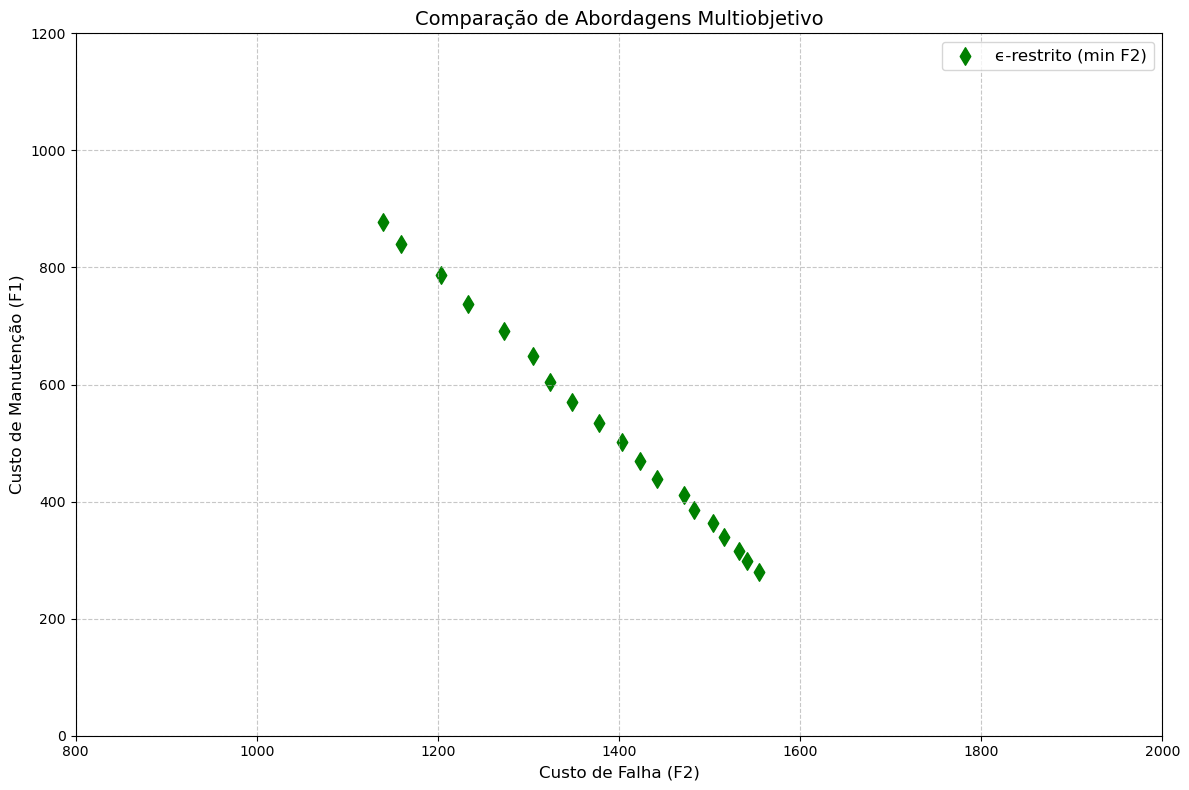

In [131]:
def gerar_resultados_epsilon_f2(dados, num_pontos=20, max_iteracoes=100):
    print("\nGerando fronteira com ϵ-restrito (min F2)...")
    f1_eps2, f2_eps2 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f2')
    
    plt.figure(figsize=(12, 8))

    # ϵ-restrito (min f2)
    plt.scatter(f2_eps2, f1_eps2, c='green', marker='d', label='ϵ-restrito (min F2)', s=80)
    
    plt.title("Comparação de Abordagens Multiobjetivo", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.xlim(800, 2000)
    plt.ylim(0, 1200)
    
    plt.tight_layout()
    plt.show()    
    
    return f1_eps2, f2_eps2

if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    
    # Gerar apenas epsilon min f2
    f1_eps2, f2_eps2 = gerar_resultados_epsilon_f2(dados, num_pontos=20, max_iteracoes=100)

**GERA RESULTADOS**


Gerando fronteira com Soma Ponderada...
Processando peso 1/10: F1=0.0%
Processando peso 2/10: F1=40.0%
Processando peso 3/10: F1=70.0%
Processando peso 4/10: F1=90.0%
Processando peso 5/10: F1=100.0%
Processando peso 6/10: F1=100.0%
Processando peso 7/10: F1=90.0%
Processando peso 8/10: F1=70.0%
Processando peso 9/10: F1=40.0%
Processando peso 10/10: F1=0.0%

Gerando fronteira com ϵ-restrito (min F1)...
Calculando soluções extremas para determinar faixa de epsilon...

Otimizando com epsilon = 1150.06 (Progresso: 1/10)

Otimizando com epsilon = 1190.70 (Progresso: 2/10)

Otimizando com epsilon = 1232.78 (Progresso: 3/10)

Otimizando com epsilon = 1276.35 (Progresso: 4/10)

Otimizando com epsilon = 1321.46 (Progresso: 5/10)

Otimizando com epsilon = 1368.16 (Progresso: 6/10)

Otimizando com epsilon = 1416.51 (Progresso: 7/10)

Otimizando com epsilon = 1466.58 (Progresso: 8/10)

Otimizando com epsilon = 1518.41 (Progresso: 9/10)

Otimizando com epsilon = 1572.07 (Progresso: 10/10)

Estat

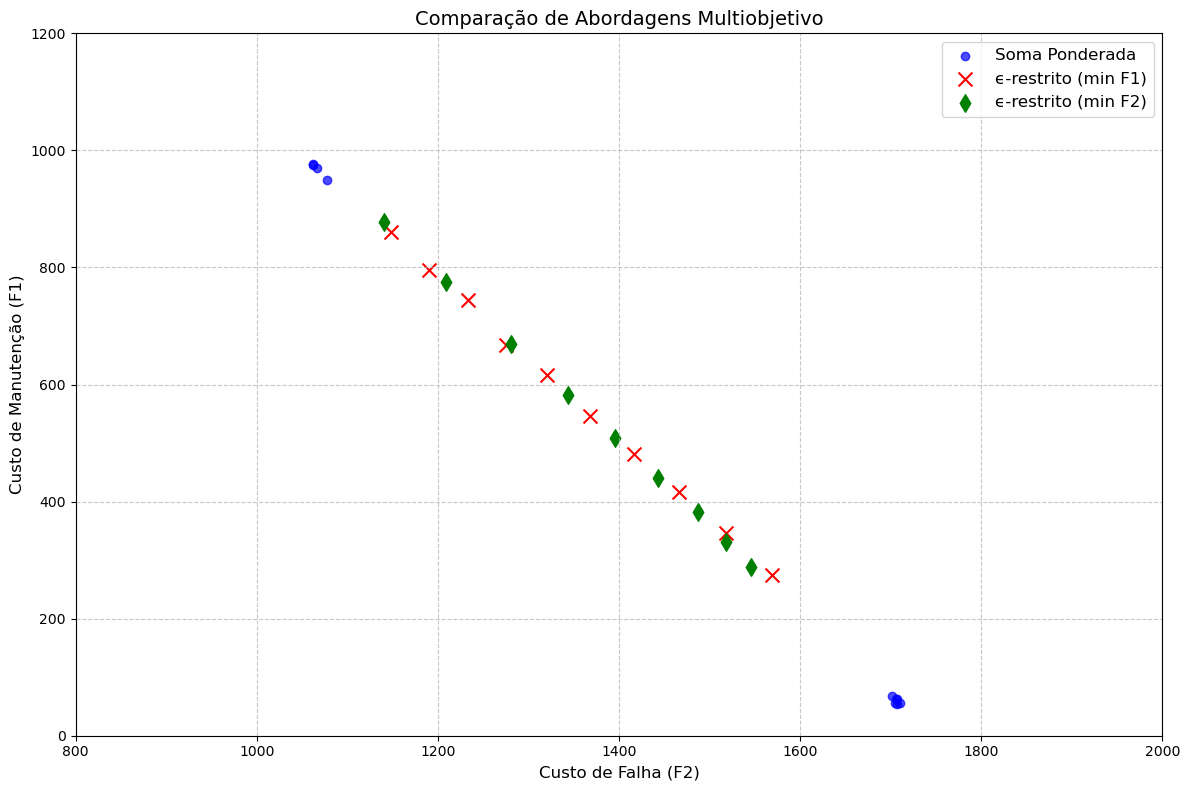

In [132]:
def plotar_resultados_comparativos(dados, num_pontos=20, max_iteracoes=100):
    # Gerar fronteiras com diferentes abordagens
    print("\nGerando fronteira com Soma Ponderada...")
    f1_pw, f2_pw = gerar_fronteira_pareto(dados, num_pontos, max_iteracoes)
    
    print("\nGerando fronteira com ϵ-restrito (min F1)...")
    f1_eps1, f2_eps1 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f1')
    
    print("\nGerando fronteira com ϵ-restrito (min F2)...")
    f1_eps2, f2_eps2 = gerar_fronteira_epsilon(dados, num_pontos, max_iteracoes, 'f2')
    
    plt.figure(figsize=(12, 8))
    
    # Soma ponderada
    plt.scatter(f2_pw, f1_pw, c='blue', marker='o', label='Soma Ponderada', alpha=0.7)
    
    # ϵ-restrito (min f1)
    plt.scatter(f2_eps1, f1_eps1, c='red', marker='x', label='ϵ-restrito (min F1)', s=100)
    
    # ϵ-restrito (min f2)
    plt.scatter(f2_eps2, f1_eps2, c='green', marker='d', label='ϵ-restrito (min F2)', s=80)
    
    plt.title("Comparação de Abordagens Multiobjetivo", fontsize=14)
    plt.xlabel("Custo de Falha (F2)", fontsize=12)
    plt.ylabel("Custo de Manutenção (F1)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    
    plt.xlim(800, 2000)
    plt.ylim(0, 1200)
    
    plt.tight_layout()
    plt.show()


# Execução principal
if __name__ == "__main__":
    dados = manutencao_def(Equipamentos, Planos)
    plotar_resultados_comparativos(dados, num_pontos=10, max_iteracoes=100)